# Retinanet

This notebooks shows an example for training Retinanet for deadwood *object detection* or *instance segmentation*.

In [ ]:
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.utils import *
from drone_detector.visualizations import *

from icevision.all import *

# Read and parse data

In [ ]:
parser = parsers.COCOBBoxParser('../data/analysis_data/coco.json', img_dir='../data/analysis_data/raster_tiles/')
class_map = ClassMap(['Standing deadwood', 'Fallen deadwood'])

In [ ]:
train, valid = parser.parse()

  0%|          | 0/4044 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126
AUTOFIX-START - ️🔨  Autofixing record with imageid: 226  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:359.8718562545255, ymin:-2.9802322387695312e-08, xmax:373.5666916379705, ymax:7.451094269752502)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 526  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:308.0198642555624, ymin:-2.9802322387695312e-08, xmax:318.5659100767225, ymax:31.770385771989822)>)) | icevision.core.bbox:autofix:70
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:169.67710564564914, ymin:-2.9802322387695312e-08, xmax:176.90326691418886, ymax:12.658670365810394)>)) | icevision.core.bbox:autofix:70
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.98023223

AUTOFIX-START - ️🔨  Autofixing record with imageid: 523  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:0.0, ymin:-2.9802322387695312e-08, xmax:49.24252237007022, ymax:58.43956929445267)>)) | icevision.core.bbox:autofix:70
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:28.753019406460226, ymin:-2.9802322387695312e-08, xmax:103.26710538566113, ymax:63.28201246261597)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 734  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:93.39407774433494, ymin:-2.9802322387695312e-08, xmax:98.19294296670705, ymax:1.8044513165950775)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 130  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin

# Set augmentations, datasets and dataloaders

`tfms.A.aug_tfms` includes various common augmentations, such as rotations, flips and random crops, as well as brightness and contrast augmenting.

In [ ]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=(384)), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train, train_tfms)
valid_ds = Dataset(valid, valid_tfms)

In [ ]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

NameError: name 'efficientdet' is not defined

# Init model

We use Mask R-CNN with pretrained ResNet50-backbone. IceVision provides easy ways to do this.

In [ ]:
model = retinanet.model(num_classes=len(class_map))

Make a fastai learner

In [ ]:
learn = retinanet.fastai.learner(dls=[train_dl, valid_dl], model=model)

Search for optimal learning rate for fine_tune

In [ ]:
learn.lr_find()

IndexError: tensors used as indices must be long, byte or bool tensors

# Train model

Train model quickly with 3e-3 as the maximum learning rate.

In [ ]:
learn.fine_tune(10, 3e-3, freeze_epochs=1)

IndexError: tensors used as indices must be long, byte or bool tensors

# See results

In [ ]:
infer_dl = mask_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = mask_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/21 [00:00<?, ?it/s]

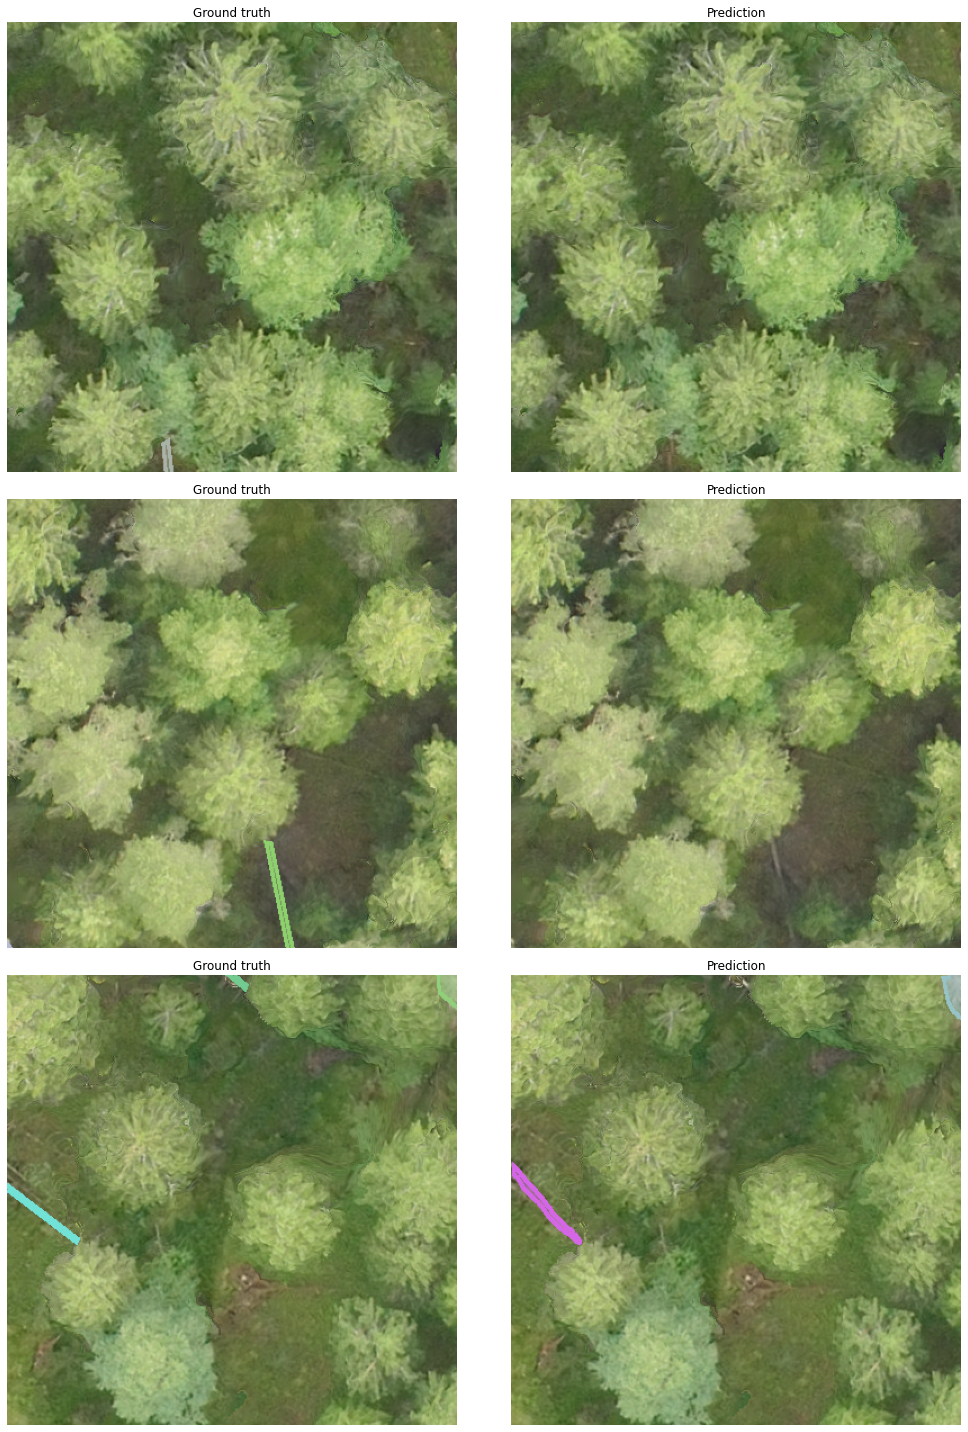

In [ ]:
ix = random.randint(0, len(samples)-3)
show_preds(
    samples=samples[ix:ix+3],
    preds=preds[ix:ix+3],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=2,
    display_label=False,
    display_bbox=False,
    figsize=(15,20)
)

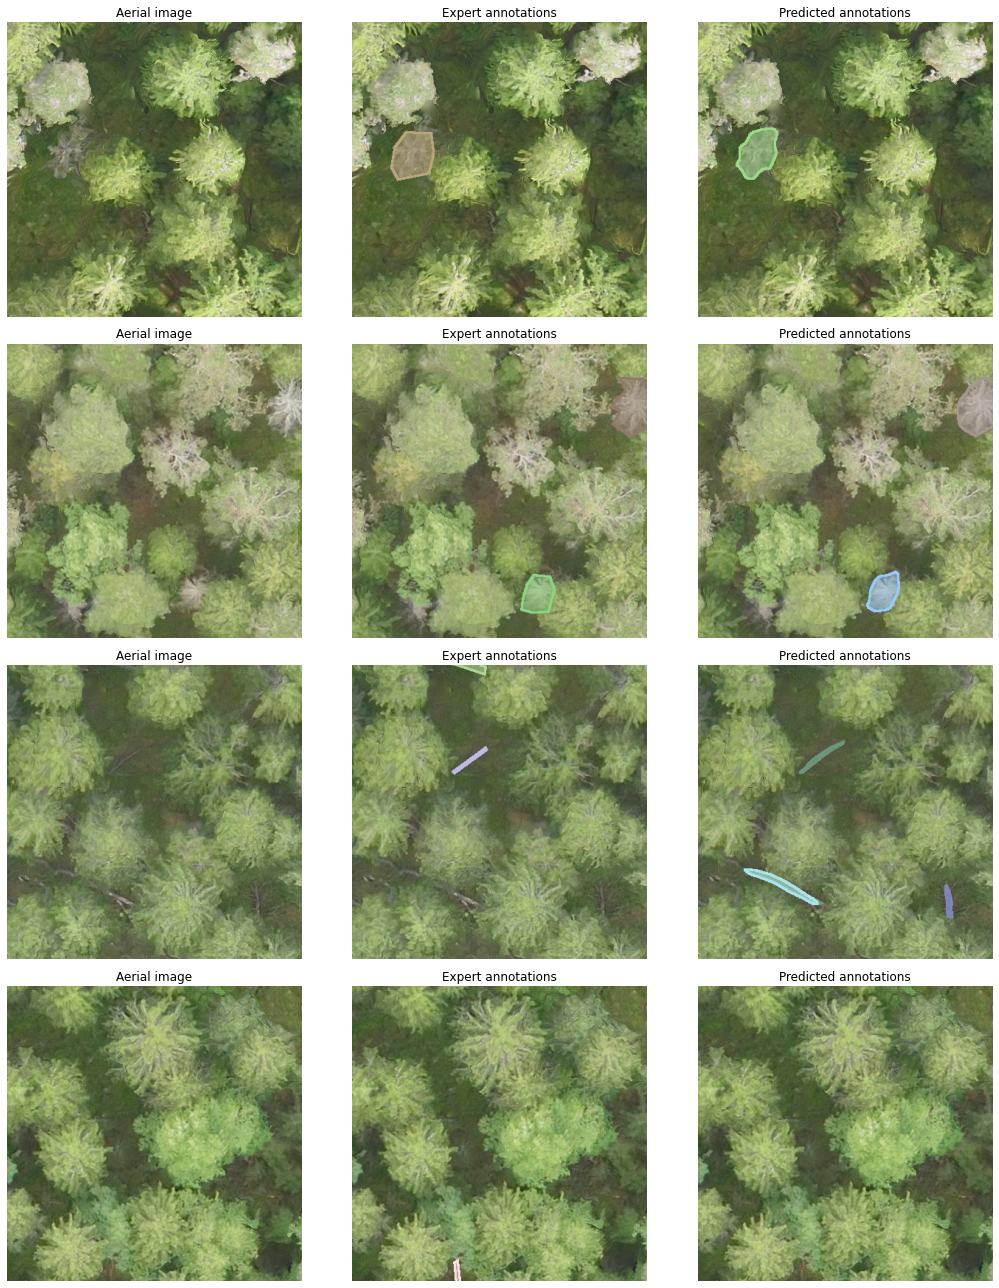

In [ ]:
ix = random.randint(0, len(samples)-4)
show_raw_mask_pred(
    samples=samples[ix:ix+4],
    preds=preds[ix:ix+4],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
    display_label=False,
    display_bbox=False,
    figsize=(15,18)
)

# Tractor is difficult

In [ ]:
import PIL

img = np.array(PIL.Image.open('../../deadwood/data/tree_patches_deadwood_sudenpesankangas/R24C17.tif'))

<AxesSubplot:>

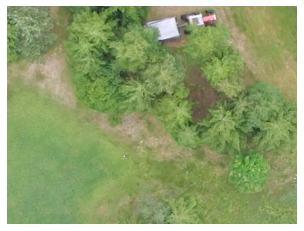

In [ ]:
show_img(img)

In [ ]:
infer_ds = Dataset.from_images([img], valid_tfms)
infer_dl = mask_rcnn.infer_dl(infer_ds, batch_size=1)
i_samples, i_preds = mask_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

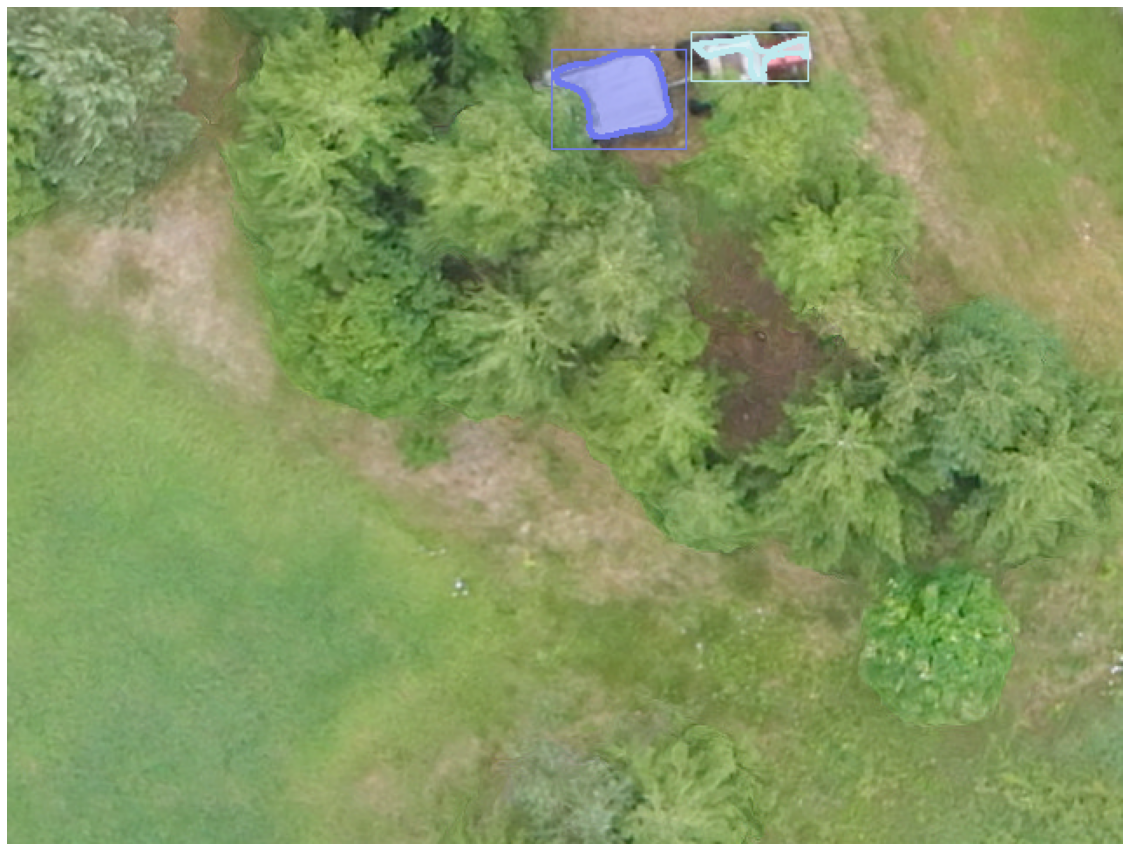

In [ ]:
fig, ax = plt.subplots(figsize=(20,18))
show_pred(
    i_samples[0]['img'],
    i_preds[0],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    display_label=False,
    display_bbox=True,
    ax=ax
)

In [ ]:
torch.save(model.state_dict(), 'models/mask-rcnn.pth')